In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity
!pwd

/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity


In [3]:
!pip3 install librosa
!pip3 install pyAudioAnalysis
!pip3 install eyed3
!pip3 install pydub
!pip3 install python_speech_features

     |████████████████████████████████| 52.4MB 55kB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.7-cp37-none-any.whl size=52589873 sha256=7b85a64b7b5be9fc1310485e37a4e5b663dfc18a1215c493c94d3429e2e74624
  Stored in directory: /root/.cache/pip/wheels/e0/da/f5/f8ab47859ae6e5f552d4fc289cc7af54879890d22bccd3d3cf
Successfully built pyAudioAnalysis
     |████████████████████████████████| 256kB 4.2MB/s 
     |████████████████████████████████| 245kB 30.4MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.5 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
  Created wheel for python-speech-features: filename=python_spee

In [4]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate

2.5.0
['id10001' 'id10002' 'id10003' 'id10004' 'id10005' 'id10006']
Current speakers shape: (6, 2)


## Dataset

We check given directory to find all available *.wav* files.

In [5]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [6]:
#check source directory and find classes
source_dir = '/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10001', 'id10002', 'id10003', 'id10004', 'id10005', 'id10006', 'id10007', 'id10008', 'id10010', 'id10009', 'id10011', 'id10012', 'id10013', 'id10014', 'id10015', 'id10016', 'id10017', 'id10018', 'id10019', 'id10020']
checking dir: /content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/Y8hIVOBuels/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/7gWzIy6yIIk/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/7w0IBEWc9Qw/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav/id10001/1zcIwhmdeo4/
/conten

In [7]:
df = pd.DataFrame(raw)
df = df[:1000]
print(df.shape)
df.head()

(1000, 2)


,speaker,path
0,id10001,/content/drive/MyDrive/Multimodal_machine_lear...
1,id10001,/content/drive/MyDrive/Multimodal_machine_lear...
2,id10001,/content/drive/MyDrive/Multimodal_machine_lear...
3,id10001,/content/drive/MyDrive/Multimodal_machine_lear...
4,id10001,/content/drive/MyDrive/Multimodal_machine_lear...


## Preprocessing and Feuture Extraction

* We split the dataset as 70% train and 30% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [8]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []

for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)

df_train = df_train.groupby('speaker')
df_train = df_train.apply(lambda x: x.sample(df_train.size().min()).reset_index(drop=True))
print(df_train, '\n')
print('Number of speaker samples for train dataset\n', df_train['speaker'].value_counts(), '\n')

df_test = df_test.groupby('speaker')
df_test = df_test.apply(lambda x: x.sample(df_test.size().min()).reset_index(drop=True))
print(df_test, '\n')
print('Number of speaker samples for train dataset\n', df_test['speaker'].value_counts(), '\n')

print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}', '\n')
# print('Number of speaker samples for train dataset\n', df_train['speaker'].value_counts(), '\n')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

            speaker                                               path
speaker                                                               
id10001 0   id10001  /content/drive/MyDrive/Multimodal_machine_lear...
        1   id10001  /content/drive/MyDrive/Multimodal_machine_lear...
        2   id10001  /content/drive/MyDrive/Multimodal_machine_lear...
        3   id10001  /content/drive/MyDrive/Multimodal_machine_lear...
        4   id10001  /content/drive/MyDrive/Multimodal_machine_lear...
...             ...                                                ...
id10011 16  id10011  /content/drive/MyDrive/Multimodal_machine_lear...
        17  id10011  /content/drive/MyDrive/Multimodal_machine_lear...
        18  id10011  /content/drive/MyDrive/Multimodal_machine_lear...
        19  id10011  /content/drive/MyDrive/Multimodal_machine_lear...
        20  id10011  /content/drive/MyDrive/Multimodal_machine_lear...

[231 rows x 2 columns] 

Number of speaker samples for train dataset
 id1001

True

In [9]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [10]:
# extract Zero Crossing Rate
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

In [11]:
df_train.head()

speaker  ...                                                zcr
speaker             ...                                                   
id10001 0  id10001  ...  [0.18695950583390528, 0.1089910775566232, 0.19...
        1  id10001  ...  [0.17437452615617893, 0.0931008339651251, 0.08...
        2  id10001  ...  [0.2151578947368421, 0.12284210526315789, 0.12...
        3  id10001  ...  [0.17780580075662042, 0.10298444724674233, 0.1...
        4  id10001  ...  [0.10844453296156144, 0.10794662417845051, 0.0...

[5 rows x 5 columns]

In [12]:
df_test.head()

speaker  ...                                                zcr
speaker             ...                                                   
id10001 0  id10001  ...  [0.11865095489638358, 0.05810646078829744, 0.1...
        1  id10001  ...  [0.17780580075662042, 0.10298444724674233, 0.1...
        2  id10001  ...  [0.14857285304748846, 0.0697993269350617, 0.11...
        3  id10001  ...  [0.10844453296156144, 0.10794662417845051, 0.0...
        4  id10001  ...  [0.0842081370935709, 0.16399024002723714, 0.05...

[5 rows x 5 columns]

In [13]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,2:5]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 11
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (161, 39), Validation set size (70, 39)


## Deep Learning Model

In [14]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4000      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [15]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 8


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
21/21 [==============================] - 1s 13ms/step - loss: 62.8791 - accuracy: 0.0683 - val_loss: 8.5633 - val_accuracy: 0.1000

Epoch 00001: val_loss improved from inf to 8.56332, saving model to saved_models/speakers_classification.hdf5
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 35.7329 - accuracy: 0.0435 - val_loss: 4.8867 - val_accuracy: 0.0429

Epoch 00002: val_loss improved from 8.56332 to 4.88666, saving model to saved_models/speakers_classification.hdf5
Epoch 3/200
21/21 [==============================] - 0s 3ms/step - loss: 25.1347 - accuracy: 0.1118 - val_loss: 2.8940 - val_accuracy: 0.0571

Epoch 00003: val_loss improved from 4.88666 to 2.89403, saving model to saved_models/speakers_classification.hdf5
Epoch 4/200
21/21 [==============================] - 0s 3ms/step - loss: 17.0464 - accuracy: 0.1118 - val_loss: 2.5054 - val_accuracy: 0.0714

Epoch 00004: val_loss improved from 2.89403 to 2.50542, saving model to saved_models/spea

### Check training history

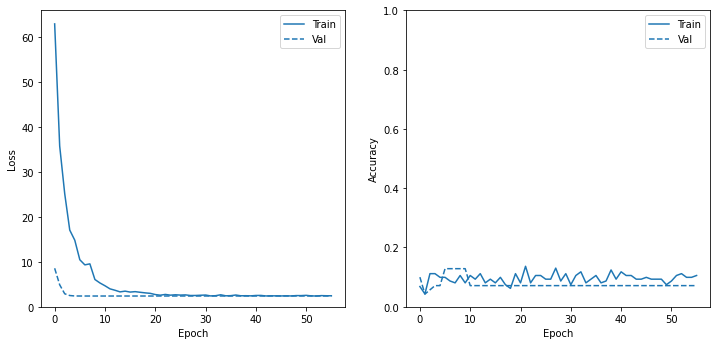

In [16]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [17]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(99, 39)
['id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004'
 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id10004' 'id1000

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gausian Mixture Model

Gaussian mixture models are a probabilistic model for representing normally distributed sub-populations within an overall population. A Gaussian mixture model is a distribution assembled from weighted multivariate Gaussian distributions. Weighting factors assign each distribution different levels of importance. The resulting model is a super-position (overlapping) of bell-shaped curves.

Gaussian mixture models are semi-parametric. Parametric implies that the model comes from a known distribution (which is in this case, a set of normal distributions). It’s semi-parametric because more components, possibly from unknown distributions, can be added to the model.

In [18]:
from sklearn import mixture

# define number of clusters
n_clusters = 7
# instantiate and fit the model
gmm = mixture.GaussianMixture(n_components=n_clusters,
                              covariance_type='diag')
                              # max_iter=200,
                              # weights_init=[0.06113069 0.28385238 0.16488565 0.27208425 0.21804704])

gmm.fit(X_train)

# check if the model has converged
print('Converged:', gmm.converged_, '\n')

# extract weight of each cluster
print('GMM weights:\n', gmm.weights_, '\n')

# extract means of each cluster
# print('GMM means:\n', gmm.means_)

# labels
y_true_gmm = df_test['speaker']

# predict
y_pred_gmm = gmm.predict(X_test)
labels = y_pred_gmm

# extract classes
y_pred_gmm = le.classes_[y_pred_gmm]
# print(y_pred_gmm, '\n')

# evaluate model
print(classification_report(y_true_gmm, y_pred_gmm, target_names=le.classes_), '\n')

# confusion matrix
confusion = metrics.confusion_matrix(y_true_gmm, y_pred_gmm)
print('Confusion Matrix\n')
print(confusion)

# save model
filename = 'saved_models/gaussian_mixture_model.sav'
pickle.dump(gmm, open(filename, 'wb'))


# # display predicted scores by the model as a contour plot
# x = np.linspace(0., 39., 39, endpoint=True)
# # np.linspace(0, 10, N, endpoint=True)
# y = np.linspace(0., 39., 39, endpoint=True)
# X, Y = np.meshgrid(x, y)
# XX = np.array([X.ravel(), Y.ravel()]).T
# Z = -clf.score_samples(XX)
# Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 10))
# CB = plt.colorbar(CS, shrink=0.8, extend='both')
# plt.scatter(X_train[:, 0], X_train[:, 1], .8)

# plt.title('Negative log-likelihood predicted by a GMM')
# plt.axis('tight')
# plt.show()

Converged: True 

GMM weights:
 [0.22797299 0.21027007 0.12554263 0.1142781  0.03104245 0.22877711
 0.06211666] 

              precision    recall  f1-score   support

     id10001       0.00      0.00      0.00         9
     id10002       0.00      0.00      0.00         9
     id10003       0.20      0.22      0.21         9
     id10004       0.20      0.33      0.25         9
     id10005       0.00      0.00      0.00         9
     id10006       0.00      0.00      0.00         9
     id10007       0.00      0.00      0.00         9
     id10008       0.00      0.00      0.00         9
     id10009       0.00      0.00      0.00         9
     id10010       0.00      0.00      0.00         9
     id10011       0.00      0.00      0.00         9

    accuracy                           0.05        99
   macro avg       0.04      0.05      0.04        99
weighted avg       0.04      0.05      0.04        99
 

Confusion Matrix

[[0 4 1 0 0 4 0 0 0 0 0]
 [5 0 3 0 0 1 0 0 0 0 0]
 [5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

Scatter plot of the data

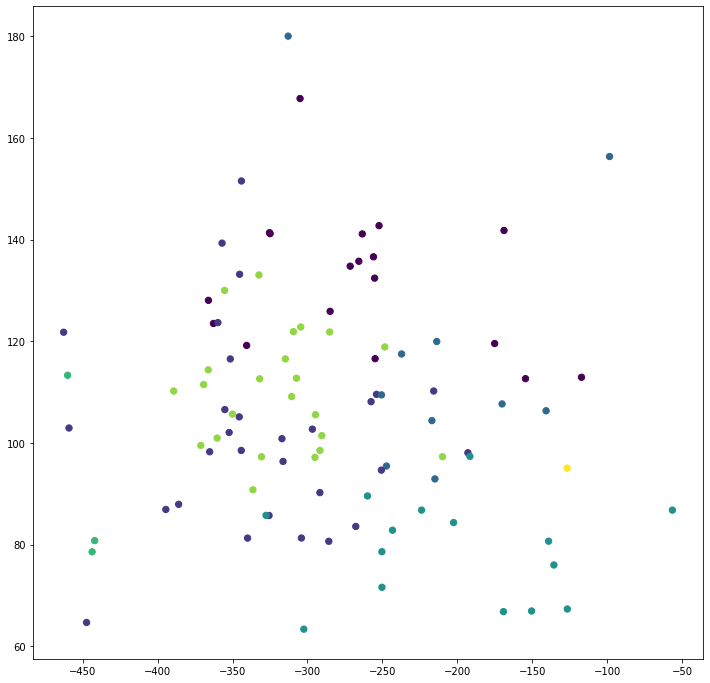

In [20]:
# scatter plot
plt.scatter(X_test[:, 0], X_test[:, 1], c=labels, s=40, cmap='viridis')

Posterior probabilities of each component

In [21]:
# posterior probabilities
probs = gmm.predict_proba(X_train)
# print(probs[:10].round(3))
print(probs.round(3))

[[0.    0.    0.    ... 0.    0.    0.998]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.    0.    1.    ... 0.    0.    0.   ]
 ...
 [1.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.    0.033 0.    ... 0.    0.    0.   ]]


Determine the best number of clusters

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

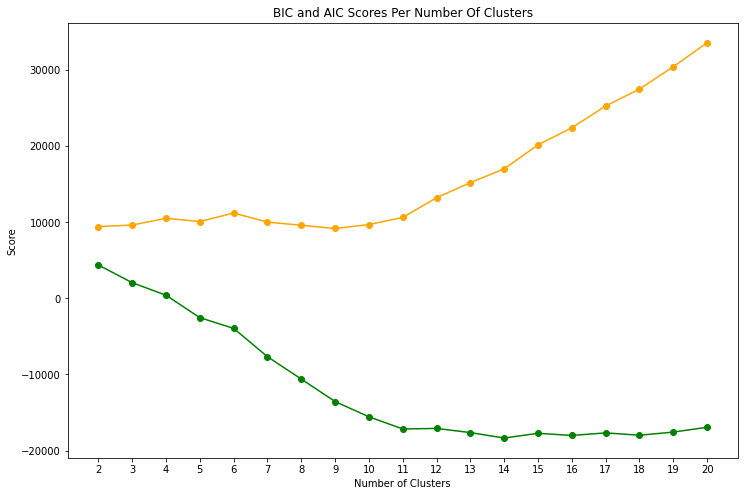

In [22]:
# Set up a range of cluster numbers to try
n_range = range(2,21)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = mixture.GaussianMixture(n_components=n, random_state=123, n_init=10)
    gm.fit(X_train)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(X_train))
    aic_score.append(gm.aic(X_train))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In [23]:
gmm_scores = gmm.score_samples(X_test)
print('GMM means of each mixture component:\n', gmm.means_, '\n')
print('GMM weighted log probabilities for each sample:\n', gmm_scores[0:20])

GMM means of each mixture component:
 [[-2.86740190e+02  1.32131479e+02  1.16644141e+00  1.91520278e+01
  -3.04527205e+00 -1.51349202e+00 -1.14590611e+01 -2.71772001e+00
  -6.58113227e+00  1.61244424e+00 -8.76740997e-01  4.90600644e-01
  -2.19342613e+00  1.14566369e-01  3.98646279e-02 -1.29906968e-02
   2.17844840e-02  1.71483069e-02 -3.05408768e-02 -2.34689533e-02
  -6.79111507e-03  4.28799154e-03 -4.37451575e-03 -8.13115645e-03
  -3.81344469e-03 -1.31518870e-02  7.81449995e-02  7.92697389e-02
   7.86106863e-02  8.98800103e-02  8.80669912e-02  7.83119193e-02
   7.82874183e-02  7.11735600e-02  8.03398479e-02  8.24351829e-02
   7.82984757e-02  8.43476160e-02  7.37945199e-02]
 [-3.27985709e+02  9.54647410e+01 -2.41019802e-01  1.27846332e+01
  -3.30496301e+00 -5.60299421e+00 -1.09286252e+01 -2.33318905e+00
  -8.60772615e+00 -4.21700081e+00 -2.34928152e+00 -4.49963786e+00
  -2.81979668e+00  2.87671408e-02  4.98055005e-02 -2.54586579e-02
   1.56363317e-03 -3.98158684e-02 -2.24956356e-02  1.